# DIP By HanXuan

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import time

import torch
from torch.autograd import Variable

from util import *
from network import *
from record import *

In [2]:
start_time = time.time()
# use cuda, or not? be prepared for a long wait if you don't have cuda capabilities.
use_cuda = True
# standard deviation of added noise after each training set
# sigma = 1./30
# number of training iterations
num_steps = 21
# number of steps to take before saving an output image
save_frequency = 10

In [3]:
# choose either 'ps' or 'dc' as the architecture used.
method = 'dc_skip5'
# input image. the architectures have been designed for 512x512 colour images
image_path = 'images/image_Baboon512rgb_noi_s40.png'
# where to put the output
expName = 'test'

In [5]:
record = experimentalRecord(basePath='../DIP_result/denoising',
                            expName=expName,
                            author='HanXuan',
                            describe='just a test',
                            fileName='Experimental Record.txt')
record.open()

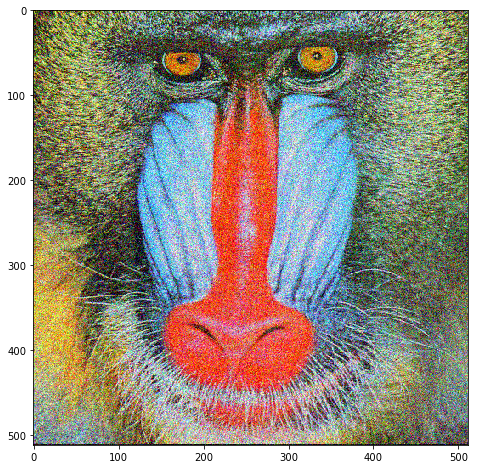

In [6]:
# import image
deconstructed = jpg_to_tensor(image_path, use_cuda)
#save the deconstructed image
record.add_image(image=deconstructed,
                imageName='origin.png',
                message='Original deconstructed image.',
                mode='TORCH_GPU_TENSOR')
# convert deconstructed to variable for calculate loss
deconstructed = Variable(deconstructed)
image_np = deconstructed.cpu().data.numpy()
plot_image(image_np,(8,8))

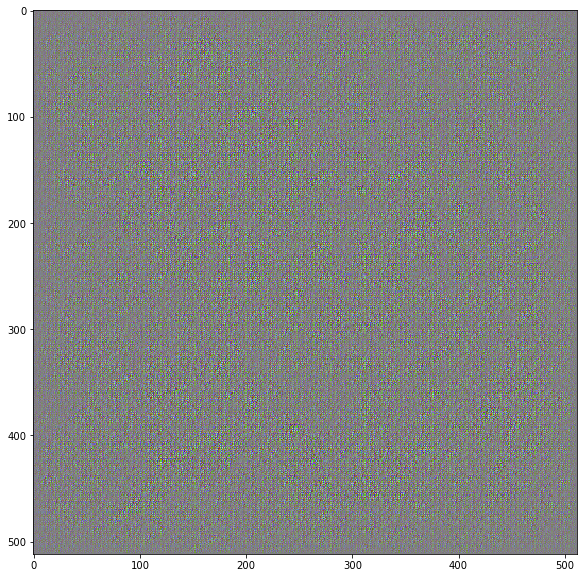

Cost time 23.700141s  At step 00000  loss is 69295.875000


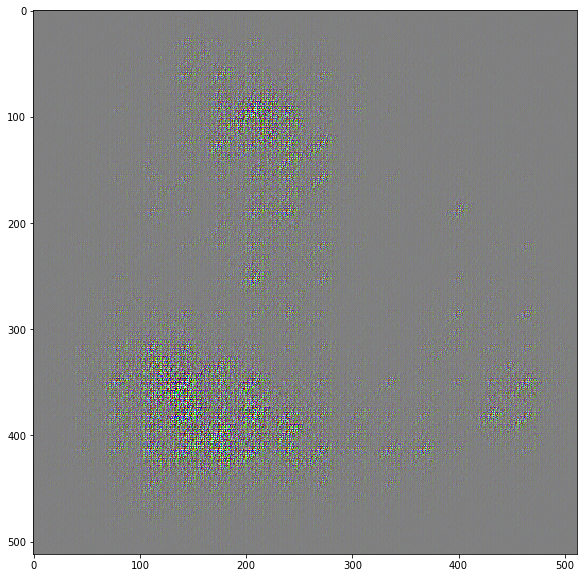

Cost time 25.085072s  At step 00010  loss is 59871.371094


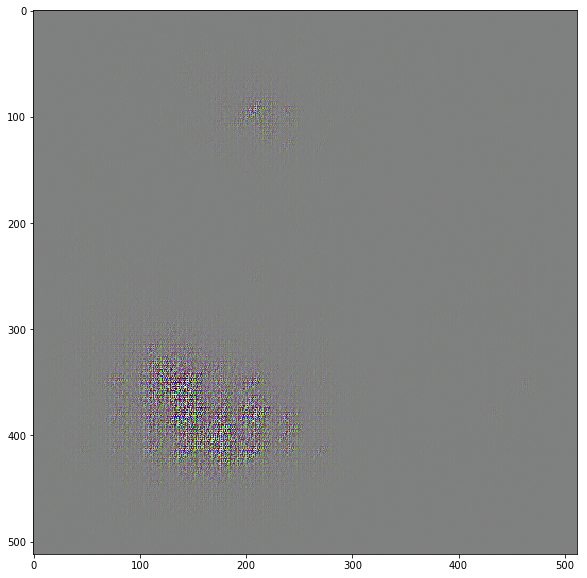

Cost time 26.589343s  At step 00020  loss is 56043.812500


In [7]:
# input of the network is noise
if use_cuda:
    noise = Variable(torch.randn(deconstructed.data.shape).cuda())
else:
    noise = Variable(torch.randn(deconstructed.data.shape))
#initialise the network with the chosen architecture
if method=='ps':
    net = pixel_shuffle_hourglass()
elif method=='dc_skip5':
    net =  deconv_hourglass_skip5()

#bind the network to the gpu if cuda is enabled

if use_cuda:
    net.cuda()
#network optimizer set up
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
#dummy index to provide names to output files
save_img_ind = 0
for step in range(num_steps):
    # get the network output
    output = net(noise)
    # calculate the l2_loss over the masked output and take an optimizer step
    optimizer.zero_grad()
    loss = torch.sum((output - deconstructed)**2)
    loss.backward()
    optimizer.step()
    #every save_frequency steps, save a jpg
    if step % save_frequency == 0:
        time_cost = time.time() - start_time
        loss_value = loss.cpu().data.numpy()[-1]
        # Cost time 236.978221s  At step 02000  loss is 28938.4121094
        print_message='Cost time %fs'%(time_cost) + '  At step %05d  loss is %f' %(step, loss_value)
        image_np = output.cpu().data.numpy()
        plot_image(image_np,(10,10))
        record.add_image(image=image_np,
                         imageName=str(save_img_ind)+'.png',
                         message=print_message,
                         mode='NP')        
        print(print_message)
        save_img_ind += 1
#     if use_cuda:
#         noise.data += sigma * torch.randn(noise.shape).cuda()
#     else:
#         noise.data += sigma * torch.randn(noise.shape)

In [8]:
record.close()